In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Stickyfy'
assert FOLDERNAME is not None, "[!] Enter the foldername."

In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.models as model
import os
from PIL import Image
from matplotlib import image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import cv2
import h5py
%matplotlib inline
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")

In [2]:
# Functions to pre process cartoon image
def remove_alpha(image, bg_color = (255,255,255)):
  if image.mode == 'RGBA':
    alpha = image.split()[-1]
    bg = Image.new("RGB", image.size, bg_color + (255,))
    bg.paste(image, mask=alpha)
    return bg
  else:
    return image
    
def preprocess(image):
  img_with_bg = remove_alpha(image)
  res_img = img_with_bg.resize((128,128))
  return res_img

class custom(object):
  def __call__(self, image):
    return remove_alpha(image)

def initialize_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    nn.init.xavier_uniform_(m.weight.data)

In [3]:
class dataset_h5(torch.utils.data.Dataset):
  def __init__(self, in_file, transforms):
    super(dataset_h5, self).__init__()
    self.file = h5py.File(in_file, 'r')
    self.transform = transforms
    self.n_images = len((self.file).keys())

  def __getitem__(self, index):
      input = self.file['X'+str(index)][:,:,:]
      input = Image.fromarray(input)
      input = self.transform(input)
      return input

  def __len__(self):
      return self.n_images

In [4]:
img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize(32),
                                       transforms.ToTensor(),
])
cartoon_file = '/content/drive/My Drive/Stickyfy/cartoon_data.h5'
cartoon_dataset_h5 = dataset_h5(cartoon_file, img_transforms)
cartoon_loader = torch.utils.data.DataLoader(cartoon_dataset_h5, shuffle = True, batch_size = 128)
face_file = '/content/drive/My Drive/Stickyfy/face_data.h5'
face_dataset_h5 = dataset_h5(face_file, img_transforms)
face_loader = torch.utils.data.DataLoader(face_dataset_h5, shuffle = True, batch_size = 128)

OSError: ignored

In [ ]:
# Unflatten module for discriminator
class Unflatten(nn.Module):
  def __init__(self,N,C,H,W):
    super(Unflatten, self).__init__()
    self.N = N
    self.W = W
    self.H = H
    self.C = C
  def forward(self,X):
    return X.view(self.N, self.C, self.H, self.W)

class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
  def forward(self, x):
    N = x.shape[0]
    return x.view(N,-1)
  
resnet18_enc = model.resnet18()
modules=list(resnet18_enc.children())[:-3]
resnet18_enc = nn.Sequential(
    *modules
)
initialize_weights(resnet18_enc)
resnet18_enc.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
class encoder_layers(nn.Module):
  def __init__(self, input_channels):
    super(encoder_layers, self).__init__()
    self.fc1 = nn.Linear(input_channels, 1024)
    self.mu_fc = nn.Linear(1024,512)
    self.var_fc = nn.Linear(1024,512)
    self.relu = nn.ReLU()
  def forward(self, X):
    fin = self.relu(self.fc1(X))
    mu = self.relu(self.mu_fc(fin))
    var = self.relu(self.var_fc(fin))
    return (mu,var)

def encoder_model(out_size):
  model = nn.Sequential(
      # Input is 32x32x3
      resnet18_enc,
      # Input is 2x2x256
      Flatten(),
      encoder_layers(out_size)
  )
  return model

def decoder_model():
  model = nn.Sequential(
      nn.Linear(512, 1024),
      Unflatten(-1, 256, 2, 2),
      nn.ConvTranspose2d(256,128,kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(),
      nn.BatchNorm2d(128),
      nn.ConvTranspose2d(128,64,kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(),
      nn.BatchNorm2d(64),
      nn.ConvTranspose2d(64,32,kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(),
      nn.BatchNorm2d(32),
      nn.ConvTranspose2d(32,16,kernel_size = 4, stride = 2, padding = 1),
      nn.Conv2d(16,3, kernel_size = 3, padding = 1, stride = 1),
      nn.Tanh(),
  )
  return model

def sample(mu, var, mode):
  temp = torch.randn_like(var)
  temp = temp.type(dtype)
  if mode == 'Training':
    z = mu + temp * var
  else:
    z = mu
  return z

resnet_face = model.resnet18()
modules=list(resnet_face.children())[:-1]
resnet_face = nn.Sequential(
    *modules,
    Flatten(),
    nn.Linear(512, 1)
)
resnet_face.to(device)

resnet_cartoon = model.resnet18()
modules=list(resnet_cartoon.children())[:-1]
resnet_cartoon = nn.Sequential(
    *modules,
    Flatten(),
    nn.Linear(512, 1)
)
resnet_cartoon.to(device)

class generator(nn.Module):
  def __init__(self, encoder, decoder):
    super(generator,self).__init__()
    self.encoder = encoder
    self.decoder = decoder
  def forward(self, X, mode):
    (mu, var) = self.encoder(X)
    z = sample(mu, var, mode)
    f_image = self.decoder(z)
    return f_image

In [ ]:
PATH = '/content/drive/My Drive/Stickyfy/Models/face_encoder.pt'
face_encoder = encoder_model(2*2*256)
face_encoder.load_state_dict(torch.load(PATH))
PATH = '/content/drive/My Drive/Stickyfy/Models/face_decoder.pt'
face_decoder = decoder_model()
face_decoder.load_state_dict(torch.load(PATH))
PATH = '/content/drive/My Drive/Stickyfy/Models/cartoon_encoder.pt'
cartoon_encoder = encoder_model(2*2*256)
cartoon_encoder.load_state_dict(torch.load(PATH))
PATH = '/content/drive/My Drive/Stickyfy/Models/cartoon_decoder.pt'
cartoon_decoder = decoder_model()
cartoon_decoder.load_state_dict(torch.load(PATH))
PATH = '/content/drive/My Drive/Stickyfy/Models/res_face.pt'
resnet_face.load_state_dict(torch.load(PATH))
PATH = '/content/drive/My Drive/Stickyfy/Models/res_cartoon.pt'
resnet_cartoon.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Losses present in network
# cycle consistency loss
def cycle_consistency_orig(X, Y):
  loss = torch.abs(X-Y)
  return loss.mean()

# Squared error loss
def se_loss(input, target):
  loss = 0.5 * ((input - target)**2)
  return loss.mean()

# Generator loss
def gen_loss(scores):
  target1 = torch.ones(scores.shape).type(dtype)
  target1.requires_grad = True
  loss = se_loss(scores, target1)
  return loss

# Discriminator loss
def dis_loss(scores, type):
  target = None
  if(type == 'real'):
    target = torch.ones(scores.shape).type(dtype)
    target.requires_grad = True
  else:
    target = torch.zeros(scores.shape).type(dtype)
    target.requires_grad = True
  loss = se_loss(scores, target)
  return loss

In [ ]:
import time
lr = 0.0002
def train_network(genA_B, genB_A, disA, disB, face_loader, cartoon_loader, num_epochs = 10, k = 1, print_every = 5):
  global lr
  da_optimizer = optim.Adam(disA.parameters(), lr = lr)
  db_optimizer = optim.Adam(disB.parameters(), lr = lr)
  gab_optimizer = optim.Adam(genA_B.parameters(), lr = lr, betas = (0.5, 0.999), weight_decay=1e-5)
  gba_optimizer = optim.Adam(genB_A.parameters(), lr = lr, betas = (0.5, 0.999), weight_decay=1e-5)
  losses_gen = []
  losses_dis_A = []
  losses_dis_B = []
  cartoon_batch = None
  face_batch = None
  t_max = min(len(cartoon_loader),len(face_loader))
  for i in np.arange(num_epochs):
    count=0
    sum_loss_gen = 0.0
    sum_loss_disA = 0.0
    sum_loss_disB = 0.0
    cartoon_iter = iter(cartoon_loader)
    face_iter = iter(face_loader)
    while True:
      start_time = time.time()
      try:
        cartoon_batch = cartoon_iter.next()
        face_batch = face_iter.next()
      except StopIteration:
        if i%print_every == print_every-1:
          print("Epoch :- {} DisA loss :- {} DisB loss :- {} gen loss :- {}".format(i+1,sum_loss_disA/count, sum_loss_disB/count, sum_loss_gen/count))
        losses_gen.append(sum_loss_gen/count)
        losses_dis_A.append(sum_loss_disA/count)
        losses_dis_B.append(sum_loss_disB/count)
        if i>=num_epochs/2:
          lr -= 0.0002/num_epochs
        break
      except:
        continue
      start_time = time.time()
      # cartoon_batch, _ = cartoon_batch
      # face_batch, _ = face_batch
      cartoon_batch = cartoon_batch.type(dtype)
      face_batch = face_batch.type(dtype)
      # print(time.time() - start_time)
      start_time = time.time()
      # fake image generation for batches
      fake_image_A_B = genA_B(face_batch, 'Training')
      fake_image_B_A = genB_A(cartoon_batch, 'Training')
      # Training discriminators with real images
      da_optimizer.zero_grad()
      db_optimizer.zero_grad()
      real_scores_A = disA(face_batch).type(dtype)
      real_scores_B = disB(cartoon_batch).type(dtype)
      lossA = dis_loss(real_scores_A, type = 'real')
      lossB = dis_loss(real_scores_B, type = 'real')
      lossA.backward(retain_graph = True)
      lossB.backward(retain_graph = True)
      da_optimizer.step()
      db_optimizer.step()
      # Training discriminators with fake image
      da_optimizer.zero_grad()
      db_optimizer.zero_grad()
      fake_scores_A = disA(fake_image_B_A).type(dtype)
      fake_scores_B = disB(fake_image_A_B).type(dtype)
      lossA = dis_loss(fake_scores_A, type = 'fake')
      lossB = dis_loss(fake_scores_B, type = 'fake')
      sum_loss_disA += lossA.item()
      sum_loss_disB += lossB.item()
      lossA.backward(retain_graph = True)
      lossB.backward(retain_graph = True)
      da_optimizer.step()
      db_optimizer.step()
      # Training generators
      gab_optimizer.zero_grad()
      gba_optimizer.zero_grad()
      cycle_image_B = genA_B(fake_image_B_A, 'Training')
      cycle_image_A = genB_A(fake_image_A_B, 'Training') 
      fake_scores_A1 = disA(fake_image_B_A).type(dtype)
      fake_scores_B1 = disB(fake_image_A_B).type(dtype)
      loss = k * cycle_consistency_orig(cartoon_batch, cycle_image_B) + gen_loss(fake_scores_A1) + gen_loss(fake_scores_B1) + k * cycle_consistency_orig(face_batch, cycle_image_A)
      sum_loss_gen += loss.item()
      loss.backward()
      gab_optimizer.step()
      gba_optimizer.step()
      count+=1
      torch.cuda.empty_cache()
      # print(time.time() - start_time)
  return (losses_gen, losses_dis_A, losses_dis_B)

In [ ]:
genA_B = generator(face_encoder, cartoon_decoder)
genB_A = generator(cartoon_encoder, face_decoder)
genA_B.to(device)
genB_A.to(device)

In [ ]:
lg, lda,ldb = train_network(genA_B, genB_A, resnet_face, resnet_cartoon, face_loader, cartoon_loader, num_epochs = 200, k =10, print_every = 1)

Epoch :- 1 DisA loss :- 0.12554851615402315 DisB loss :- 0.024892715853638947 gen loss :- 3.6320448194231307
Epoch :- 2 DisA loss :- 0.11286069284862196 DisB loss :- 0.0160501414965707 gen loss :- 3.774251256190555
Epoch :- 3 DisA loss :- 0.11985254607030324 DisB loss :- 0.018439306776937364 gen loss :- 3.6398413726261682
Epoch :- 4 DisA loss :- 0.12210488069270338 DisB loss :- 0.013827752450015395 gen loss :- 3.569494114603315
Epoch :- 5 DisA loss :- 0.11214987555859794 DisB loss :- 0.01961426155536737 gen loss :- 3.7616784505441156
Epoch :- 6 DisA loss :- 0.12097416046193578 DisB loss :- 0.02052893576992702 gen loss :- 3.6303048704711482
Epoch :- 7 DisA loss :- 0.10072008174444948 DisB loss :- 0.0331320395826229 gen loss :- 3.8265102556773596
Epoch :- 8 DisA loss :- 0.11192725619799654 DisB loss :- 0.02564886933304107 gen loss :- 3.643678064077673
Epoch :- 9 DisA loss :- 0.12450351240769239 DisB loss :- 0.01745486445724964 gen loss :- 3.7090678147866694
Epoch :- 10 DisA loss :- 0.114

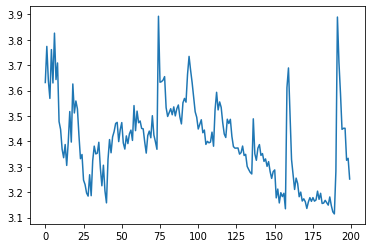

In [ ]:
range = np.arange(200)
loss_t = []
for l in lg:
  loss_t.append(float(l))
plt.plot(range, loss_t)

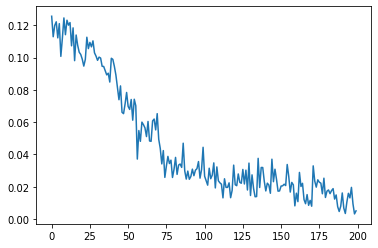

In [ ]:
range = np.arange(200)
loss_t = []
for l in lda:
  loss_t.append(float(l))
plt.plot(range, loss_t)

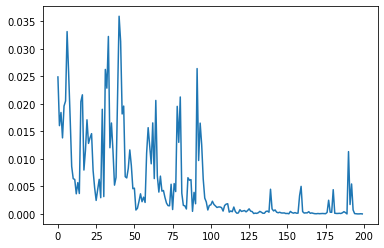

In [ ]:
range = np.arange(200)
loss_t = []
for l in ldb:
  loss_t.append(float(l))
plt.plot(range, loss_t)

In [ ]:
# Test images loader
target_path = '/content/drive/My Drive/Stickyfy/Test_images/cropped_faces/'
def test_data_loader(data_dir):
  img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize((32,32)),
                                       transforms.ToTensor(),
  ])
  test_data = datasets.ImageFolder(data_dir, transform = img_transforms)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1)
  return test_loader

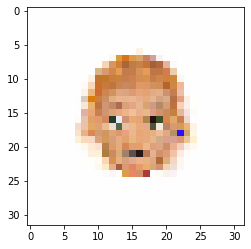

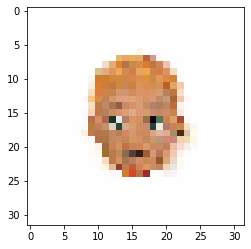

In [ ]:
# Final tests
test_loader = test_data_loader(target_path)
i = 0
with torch.no_grad():
  for image,_ in test_loader:
    trans = transforms.ToPILImage(mode='RGB')
    image = image.type(dtype)
    img2 = genA_B(image,'Test')
    # print(resnet_cartoon(img2))
    img2 = img2.to(torch.device('cpu'))
    img = trans(img2.squeeze())
    r,g,b = img.split()
    img = Image.merge('RGB', (b,g,r))
    plt.imshow(img)
    plt.show()